In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Loading and preprocessing the dataset

In [2]:
data = pd.read_csv("../input/twitter-sentiment-dataset/Twitter_Data.csv")
data.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
data.isnull().sum()

clean_text    4
category      7
dtype: int64

In [4]:
data.shape

(162980, 2)

In [5]:
data.category.nunique(), data.category.unique()

(3, array([-1.,  0.,  1., nan]))

In [6]:
data = data.dropna()
data.isnull().sum()

clean_text    0
category      0
dtype: int64

## Shuffling the dataset

In [7]:
data = data.sample(frac = 1).reset_index(drop = True)
data.head(5)

,clean_text,category
0,drdo exchief upa didn’ give nod but modi had t...,1.0
1,india can guide the world combating climate ch...,0.0
2,this our india and leftists intellectuals blam...,0.0
3,perfect example goldbricking rahul gandhi this...,1.0
4,\ncongress pdp responsible for problems narend...,1.0


## One hot encoding of the labels

In [8]:
labels = pd.get_dummies(data.category)
labels.columns = ["negative", "neutral", "positive"]
labels.head(5)

,negative,neutral,positive
0,0,0,1
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1


## Dropping instances with null values, since we have plenty of data

In [9]:
data = data.drop(columns = "category")
data.head(3)

,clean_text
0,drdo exchief upa didn’ give nod but modi had t...
1,india can guide the world combating climate ch...
2,this our india and leftists intellectuals blam...


## Tokenization

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = 8150, lower = True, split = " ", oov_token = "~")
tokenizer.fit_on_texts(data["clean_text"])

In [11]:
word_index = tokenizer.word_index
len(word_index)

113679

In [13]:
print(list(word_index.keys())[:100]) #first 100 tokens in word_index

['~', 'modi', 'the', 'and', 'for', 'you', 'not', 'will', 'this', 'india', 'are', 'that', 'with', 'has', 'have', 'but', 'all', 'from', 'was', 'his', 'they', 'bjp', 'who', 'people', 'what', 'congress', 'like', 'your', 'only', 'now', 'narendra', 'can', 'why', 'our', 'its', 'govt', 'about', 'one', 'vote', 'dont', 'him', 'just', 'when', 'their', 'modis', 'more', 'country', 'how', 'election', 'years', 'should', 'time', 'rahul', 'did', 'indian', 'any', 'against', 'nation', 'even', 'after', 'then', 'also', 'which', 'there', 'out', 'know', 'government', 'again', 'them', 'get', 'power', 'want', 'had', 'gandhi', 'because', 'than', 'minister', 'good', 'give', 'these', 'been', 'would', 'space', 'money', 'said', 'says', 'under', 'see', 'hai', 'done', 'credit', 'party', 'sir', 'pakistan', 'make', 'were', 'prime', 'every', 'think', 'say']


In [14]:
data["clean_text"] = tokenizer.texts_to_sequences(data["clean_text"])

In [15]:
data.head(3)

,clean_text
0,"[132, 2807, 187, 718, 79, 1779, 16, 2, 73, 3, ..."
1,"[10, 32, 4973, 3, 128, 1, 4910, 299, 2, 102, 1..."
2,"[9, 34, 10, 4, 4270, 2154, 423, 2, 4, 22, 5, 246]"


In [17]:
len(data.clean_text[0]), len(data.clean_text[1]), len(data.clean_text[2])
#length of the sequences are different

(37, 12, 12)

In [18]:
tweets = pad_sequences(data["clean_text"]) #padding the sequences to get same shapes

In [19]:
tweets[0].shape, tweets[1].shape, tweets[2].shape
#now length of each sequence is same

((52,), (52,), (52,))

In [20]:
tweets.shape

(162969, 52)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size = 0.15)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((138523, 52), (138523, 3), (24446, 52), (24446, 3))

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

In [24]:
print(f"""
Training set: tweets = {X_train.shape}, labels = {y_train.shape},
Validation set: tweets = {X_valid.shape}, labels = {y_valid.shape},
Test set: tweets = {X_test.shape}, labels = {y_test.shape}
""")


Training set: tweets = (110818, 52), labels = (110818, 3),
Validation set: tweets = (27705, 52), labels = (27705, 3),
Test set: tweets = (24446, 52), labels = (24446, 3)



# Defining and training the model

In [44]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = 8150, output_dim = 32),
    keras.layers.GRU(128),
    keras.layers.Dense(128, activation = "leaky_relu", kernel_initializer = "he_normal", kernel_regularizer = "l1"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation = "softmax", kernel_initializer = "glorot_normal")
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          260800    
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               62208     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 387       
Total params: 339,907
Trainable params: 339,907
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [46]:
history = model.fit(
    X_train, y_train, 
    epochs = 500, validation_data = (X_valid, y_valid),
    callbacks = [keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)]
)

Epoch 1/500
3464/3464 [==============================] - 22s 6ms/step - loss: 0.9502 - accuracy: 0.8423 - val_loss: 0.3592 - val_accuracy: 0.9401
Epoch 2/500
3464/3464 [==============================] - 20s 6ms/step - loss: 0.3211 - accuracy: 0.9523 - val_loss: 0.2760 - val_accuracy: 0.9594
Epoch 3/500
3464/3464 [==============================] - 21s 6ms/step - loss: 0.2781 - accuracy: 0.9634 - val_loss: 0.2472 - val_accuracy: 0.9659
Epoch 4/500
3464/3464 [==============================] - 21s 6ms/step - loss: 0.2515 - accuracy: 0.9696 - val_loss: 0.2440 - val_accuracy: 0.9681
Epoch 5/500
3464/3464 [==============================] - 20s 6ms/step - loss: 0.2374 - accuracy: 0.9735 - val_loss: 0.2657 - val_accuracy: 0.9652
Epoch 6/500
3464/3464 [==============================] - 21s 6ms/step - loss: 0.2254 - accuracy: 0.9757 - val_loss: 0.2594 - val_accuracy: 0.9662
Epoch 7/500
3464/3464 [==============================] - 20s 6ms/step - loss: 0.2140 - accuracy: 0.9785 - val_loss: 0.2492 -

In [47]:
model.evaluate(X_test, y_test)

764/764 [==============================] - 2s 3ms/step - loss: 0.2463 - accuracy: 0.9669


[0.24634042382240295, 0.9669066667556763]

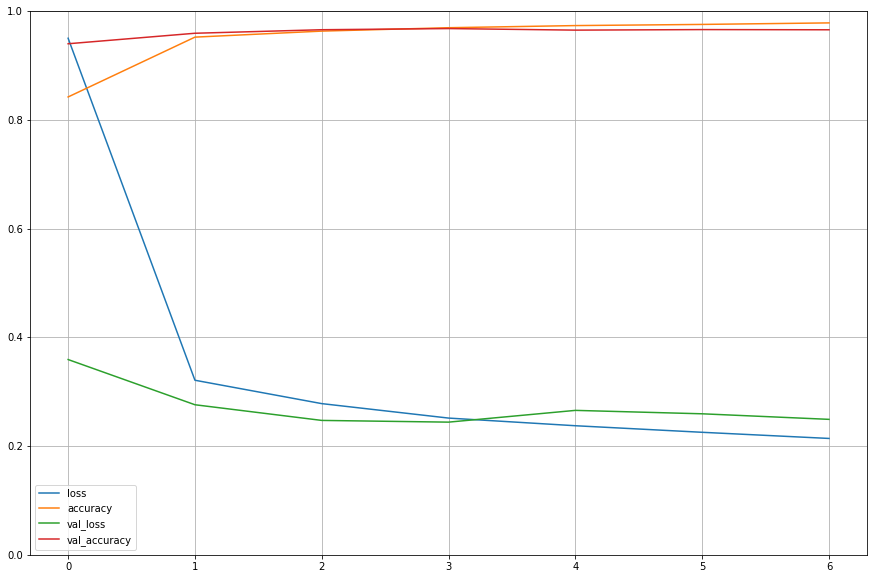

In [48]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize = (15, 10))
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [49]:
model.save("twitter_project_96.7%.h5")